In [1]:
from main import main
from PDconfig import LaVoz
from archivosDF import *

main()
ruta_barrios = './DataFrames/LaVoz/barrios.csv'
ruta_ciudades = './DataFrames/LaVoz/ciudades.csv'
df = abrirDF(LaVoz)

In [2]:
# Completar datos:
filt = df["terrenoEdificado"].isna() & df["tipoPropiedad"] == "DEPARTAMENTO"
df.loc[filt, "terrenoEdificado"] = df.loc[filt, "terrenoTotal"]

In [3]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df = df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado', 'cantDormitorios', 'cantBanos', 'cantCochera'])

# CAMBIAR TIPOS PROP
reemplazos = {
  "DUPLEX" : "CASA",
  "DÚPLEX" : "CASA",
  "TRIPLEX" : "CASA",
  "CHALET" : "CASA", 
  "PREFABRICADA": "CASA", 
  "CABAÑA" : "CASA",
  "SEMIPISO" : "DEPARTAMENTO",
  "PISO" : "DEPARTAMENTO",
  "PENTHOUSE" : "DEPARTAMENTO",
  "LOFT" : "DEPARTAMENTO"
}
df["tipoPropiedad"].replace(reemplazos, inplace= True)

# ELIMINAR TIPO PROP INSERVIBLES
filt = (df["tipoPropiedad"] == "CASA") | (df["tipoPropiedad"] == "DEPARTAMENTO") | (df["tipoPropiedad"] == "TERRENOS LOTES")
df = df.loc[filt]

# SEPARAR TERRENOS/LOTES DEL RESTO
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS LOTES"]
inmuebles = df.loc[df["tipoPropiedad"] != "TERRENOS LOTES"]

In [4]:
# FILTRADO DETALLADO INMUEBLES
filtro_TT = inmuebles["terrenoTotal"].between(inmuebles["terrenoTotal"].quantile(0.01179), 
                                          inmuebles["terrenoTotal"].quantile(0.992))
filtro_P = inmuebles["precioUSD"].between(inmuebles["precioUSD"].quantile(0.01179), 
                                          inmuebles["precioUSD"].quantile(0.992))
inmuebles_filt = inmuebles.loc[filtro_TT & filtro_P]

# Convert the 'fechaUltimaActualizacion' column to datetime objects
inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], errors='coerce', format='mixed', dayfirst=True)
inmuebles_filt= inmuebles_filt[inmuebles_filt['fechaUltimaActualizacion'].dt.year == 2023]

# FILTRADO DETALLADO TERRENOS
filtro_TT = terrenos["terrenoTotal"].between(terrenos["terrenoTotal"].quantile(0.025), 
                                          terrenos["terrenoTotal"].quantile(0.99))
filtro_P = terrenos["precioUSD"].between(terrenos["precioUSD"].quantile(0.025), 
                                          terrenos["precioUSD"].quantile(0.99))

terrenos_filt = terrenos.loc[filtro_TT & filtro_P]

C:\Users\benja\AppData\Local\Temp\ipykernel_17720\334319019.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inmuebles_filt['fechaUltimaActualizacion'] = pd.to_datetime(inmuebles_filt['fechaUltimaActualizacion'], errors='coerce', format='mixed', dayfirst=True)


In [5]:
# Agrupar barrios
g_barrios = inmuebles_filt.groupby(['barrio', 'ciudad'])

# Calculamos Precio Promedio por barrio
costo_prom_barrio = g_barrios['precioUSD'].mean().round(0)
std_costo_barrio = g_barrios['precioUSD'].std().round(0)
costo_med_barrio = g_barrios['precioUSD'].median().round(0)

# Step 3: Calculate the cost per square meter ($/m2) for each group (including houses with barrio)
inmuebles_filt.loc[:, 'precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt.loc[:, 'precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

costo_prom_m2_tot_barrio = g_barrios['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_barrio = g_barrios['precio_m2_edif'].mean().round(0)

std_costo_m2_tot_barrio = g_barrios['precio_m2_total'].std().round(0)
std_costo_m2_edif_barrio = g_barrios['precio_m2_edif'].std().round(0)

costo_med_m2_tot_barrio = g_barrios['precio_m2_total'].median().round(0)
costo_med_m2_edif_barrio = g_barrios['precio_m2_edif'].median().round(0)

# Step 4: Count the number of houses being sold in each group (including houses with barrio)
inmuebles_por_barrio = g_barrios.size()

# Add the results for barrio-level statistics to the city results
resultados_barrio = pd.DataFrame({
    'Costo Prom': costo_prom_barrio,
    'STD Costo' : std_costo_barrio,
    'Costo Med': costo_med_barrio,
    'Prom $/m2 Total': costo_prom_m2_tot_barrio,
    'STD $/m2 Total' : std_costo_m2_tot_barrio,
    'Med $/m2 Total': costo_med_m2_tot_barrio,
    'Prom $/m2 Edif': costo_prom_m2_edif_barrio,
    'STD $/m2 Edif' : std_costo_m2_edif_barrio,
    'Med $/m2 Edif': costo_med_m2_edif_barrio,
    'Cant': inmuebles_por_barrio
}).reset_index()

In [6]:
# Step 5: Group the data by 'ciudad' only (excluding barrio)
g_ciudad = inmuebles_filt.groupby('ciudad')

# Step 6: Calculate the average house cost for each group (excluding barrio)
costo_prom_ciudad = g_ciudad['precioUSD'].mean().round(0)
std_costo_ciudad = g_ciudad['precioUSD'].std().round(0)
costo_med_ciudad = g_ciudad['precioUSD'].median().round(0)

# Step 7: Calculate the cost per square meter ($/m2) for each group (excluding barrio)
costo_prom_m2_tot_ciudad = g_ciudad['precio_m2_total'].mean().round(0)
costo_prom_m2_edif_ciudad = g_ciudad['precio_m2_edif'].mean().round(0)

std_costo_m2_tot_ciudad = g_ciudad['precio_m2_total'].std().round(0)
std_costo_m2_edif_ciudad = g_ciudad['precio_m2_edif'].std().round(0)

costo_med_m2_tot_ciudad = g_ciudad['precio_m2_total'].median().round(0)
costo_med_m2_edif_ciudad = g_ciudad['precio_m2_edif'].median().round(0)

# Step 8: Count the number of houses being sold in each group (excluding barrio)
inmuebles_por_ciudad = g_ciudad.size()

# Merge the results for city-level statistics
resultados_ciudad = pd.DataFrame({
    'Costo Prom': costo_prom_ciudad,
    'STD Costo' : std_costo_ciudad,
    'Costo Med': costo_med_ciudad,
    'Prom $/m2 Total': costo_prom_m2_tot_ciudad,
    'STD $/m2 Total' : std_costo_m2_tot_ciudad,
    'Med $/m2 Total': costo_med_m2_tot_ciudad,
    'Prom $/m2 Edif': costo_prom_m2_edif_ciudad,
    'STD $/m2 Edif' : std_costo_m2_edif_ciudad,
    'Med $/m2 Edif': costo_med_m2_edif_ciudad,
    'Cant': inmuebles_por_ciudad
}).reset_index()

93


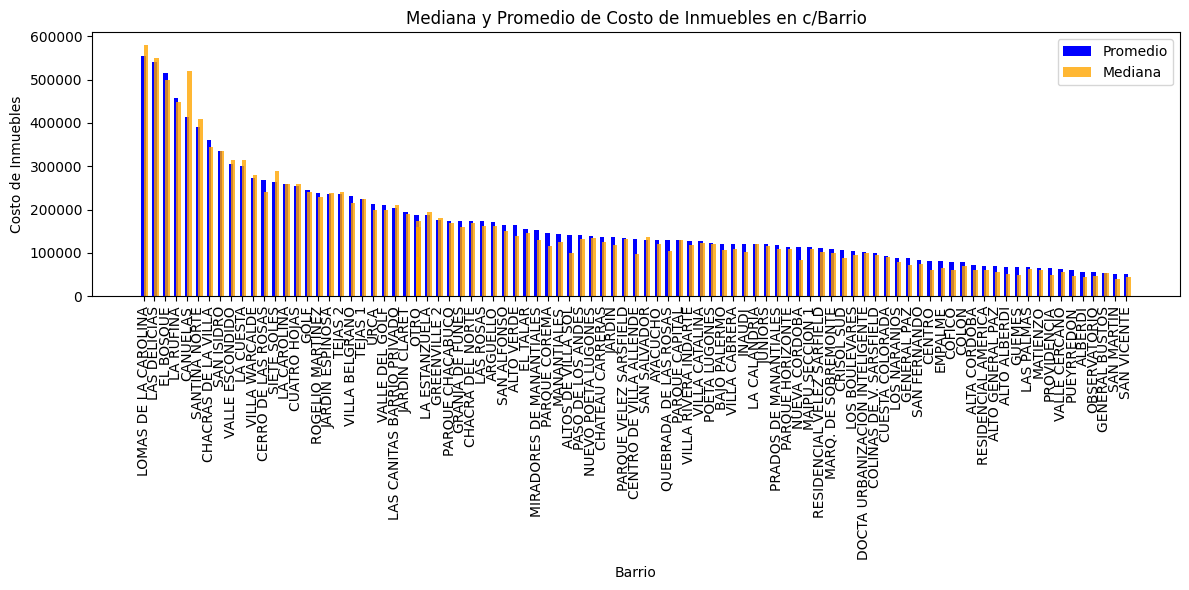

In [13]:
import matplotlib.pyplot as plt

resultados_barrio_sorted = resultados_barrio.sort_values(by='Costo Prom', ascending=False)
resultados_barrio_sorted = resultados_barrio_sorted.loc[resultados_barrio_sorted['Cant'] > 30]

plt.figure(figsize=(12, 6))
barrio_names = resultados_barrio_sorted['barrio']
print(len(barrio_names))
bar_width = 0.4

plt.bar(barrio_names, resultados_barrio_sorted['Costo Prom'], width=bar_width, label='Promedio', color='blue')

plt.bar(barrio_names, resultados_barrio_sorted['Costo Med'], width=bar_width, label='Mediana', color='orange', alpha=0.8, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('Costo de Inmuebles')
plt.title('Mediana y Promedio de Costo de Inmuebles en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

# Step 2: Calculate the price per squared meter ($/m²) for each group
inmuebles_filt['precio_m2_total'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoTotal']
inmuebles_filt['precio_m2_edif'] = inmuebles_filt['precioUSD'] / inmuebles_filt['terrenoEdificado']

# Step 1: Group the data by 'ciudad', 'barrio', and 'tipoPropiedad'
grouped_data = inmuebles_filt.groupby(['ciudad', 'barrio', 'tipoPropiedad'])

# Step 3: Calculate the mean price per squared meter for each group
precio_m2_total_mean = grouped_data['precio_m2_total'].mean()
precio_m2_total_median = grouped_data['precio_m2_total'].median()
precio_m2_edif_mean = grouped_data['precio_m2_edif'].mean()
precio_m2_edif_median = grouped_data['precio_m2_edif'].median()

# Step 4: Calculate the count of properties in each group
group_counts = grouped_data.size()

# Reset index to convert the grouped results to DataFrames
precio_m2_total_mean_df = precio_m2_total_mean.reset_index()
precio_m2_edif_mean_df = precio_m2_edif_mean.reset_index()
precio_m2_total_median_df = precio_m2_total_median.reset_index()
precio_m2_edif_median_df = precio_m2_edif_median.reset_index()

# Rename columns for clarity
precio_m2_total_mean_df.rename(columns={'precio_m2_total': 'Precio m2 Total Mean'}, inplace=True)
precio_m2_edif_mean_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Mean'}, inplace=True)
precio_m2_total_median_df.rename(columns={'precio_m2_total': 'Precio m2 Total Median'}, inplace=True)
precio_m2_edif_median_df.rename(columns={'precio_m2_edif': 'Precio m2 Edif Median'}, inplace=True)

# Step 5: Add the count column to each DataFrame
precio_m2_edif_median_df['Count'] = group_counts.values

# Step 6: Merge the results into a single DataFrame
merged_df = pd.merge(precio_m2_total_mean_df, precio_m2_edif_mean_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_total_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])
merged_df = pd.merge(merged_df, precio_m2_edif_median_df, on=['ciudad', 'barrio', 'tipoPropiedad'])


merged_df["Total Delta"] = abs(merged_df["Precio m2 Total Mean"] - merged_df['Precio m2 Total Median'])
merged_df["Edif Delta"] = abs(merged_df["Precio m2 Edif Mean"] - merged_df['Precio m2 Edif Median'])
# Print the DataFrame with price per squared meter and count for each group
merged_df


,ciudad,barrio,tipoPropiedad,Precio m2 Total Mean,Precio m2 Edif Mean,Precio m2 Total Median,Precio m2 Edif Median,Count,Total Delta,Edif Delta
0,A.T.E.,ANISACATE,CASA,67.096774,297.142857,67.096774,297.142857,1,0.000000,0.000000
1,CABANA DEL PILAR,VILLA ALLENDE,CASA,330.000000,550.000000,330.000000,550.000000,1,0.000000,0.000000
2,CABANA DEL PILAR,VILLA CARLOS PAZ,CASA,61.111111,825.000000,61.111111,825.000000,1,0.000000,0.000000
3,CAUSANA,MALAGUENO,CASA,587.712463,1175.968811,307.719298,1000.000000,4,279.993165,175.968811
4,CORDOBA,10 DE AGOSTO,CASA,350.995394,929.049444,237.603120,646.380594,12,113.392274,282.668851
...,...,...,...,...,...,...,...,...,...,...
670,VILLA ALLENDE,SAN ISIDRO,CASA,417.205168,1078.072991,377.551020,1071.428571,41,39.654147,6.644420
671,VILLA ALLENDE,SAN ISIDRO,DEPARTAMENTO,1113.333333,NaN,906.666667,NaN,3,206.666667,NaN
672,VILLA ALLENDE,SOLARES DE SAN ALFONSO,CASA,394.520369,1126.424829,360.195360,1066.666667,11,34.325008,59.758162
673,VILLA ALLENDE,TERRAZAS DE VILLA ALLENDE,CASA,302.757537,836.846593,294.573643,826.086957,7,8.183893,10.759637


19


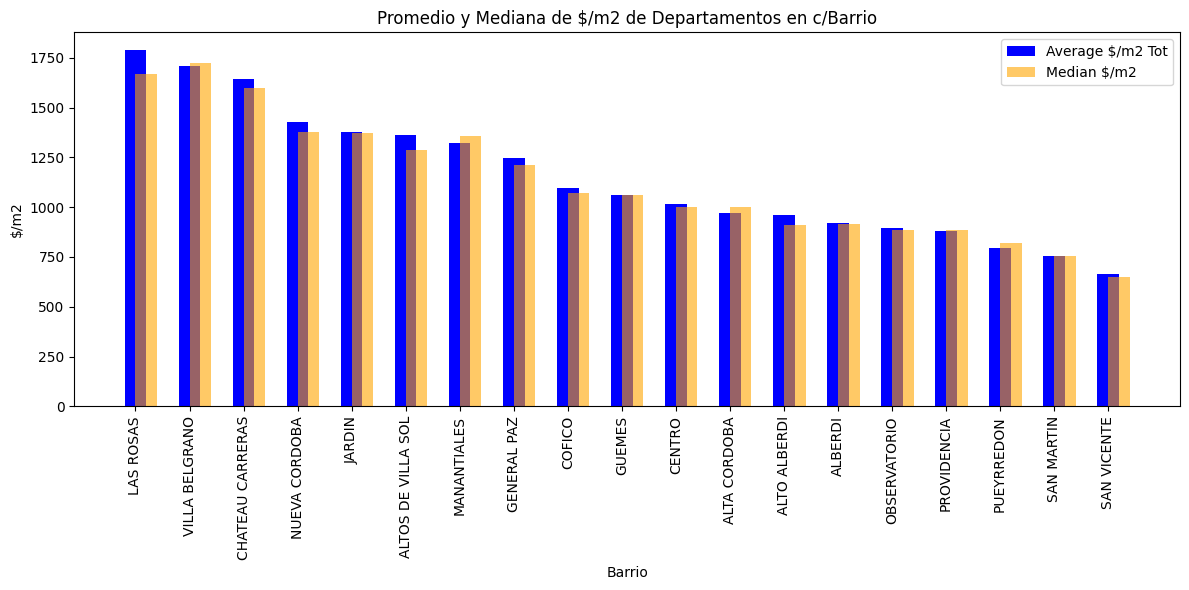

In [27]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
departamento_df = merged_df.sort_values("Precio m2 Total Mean", ascending=False)
departamento_df = departamento_df[(departamento_df['tipoPropiedad'] == 'DEPARTAMENTO') & (departamento_df["Count"] > 30)]
plt.figure(figsize=(12, 6))
barrio_names = departamento_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, departamento_df['Precio m2 Total Mean'], width=bar_width, label='Average $/m2 Tot', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, departamento_df['Precio m2 Total Median'], width=bar_width, label='Median $/m2', color='orange', alpha=0.6, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


76


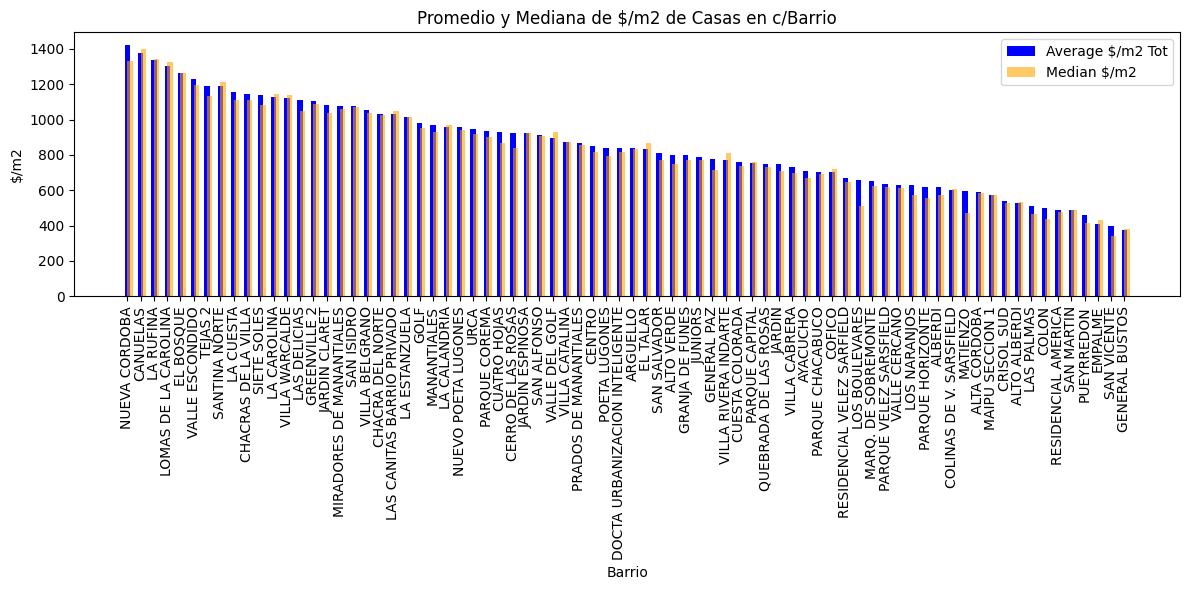

In [26]:
import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
casa_df = merged_df.sort_values("Precio m2 Edif Mean", ascending=False)
casa_df = casa_df[(casa_df['tipoPropiedad'] == 'CASA') & (casa_df["Count"] > 30) & (casa_df['barrio'] != 'OTRO')]
plt.figure(figsize=(12, 6))
barrio_names = casa_df['barrio']
print(len(barrio_names))
bar_width = 0.4

# Plot the bar for average house cost
plt.bar(barrio_names, casa_df['Precio m2 Edif Mean'], width=bar_width, label='Average $/m2 Tot', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, casa_df['Precio m2 Edif Median'], width=bar_width, label='Median $/m2', color='orange', alpha=0.6, align='edge')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Promedio y Mediana de $/m2 de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


,ciudad,barrio,tipoPropiedad,Precio m2 Total Mean,Precio m2 Edif Mean,Precio m2 Total Median,Precio m2 Edif Median,Count,Total Delta,Edif Delta
332,CORDOBA,NUEVA CORDOBA,DEPARTAMENTO,1429.830956,NaN,1377.952756,NaN,1501,51.8782,NaN
